# Baseline Model

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (IndexLocator, FormatStrFormatter, AutoMinorLocator)
%matplotlib inline

conso = pd.read_csv('Ressources/Consommation des ménages trimestrielle.csv',sep=';')
conso = conso.set_index('Période').replace({',':'.'},regex=True).astype('float64')
conso.index = pd.to_datetime(conso.index.str.replace('T1','-03-31').str.replace('T2','-06-30').str.replace('T3','-09-30').str.replace('T4','-12-31'))

yty_var = conso['TOTAL ']/conso['TOTAL '].shift(periods=4) - 1

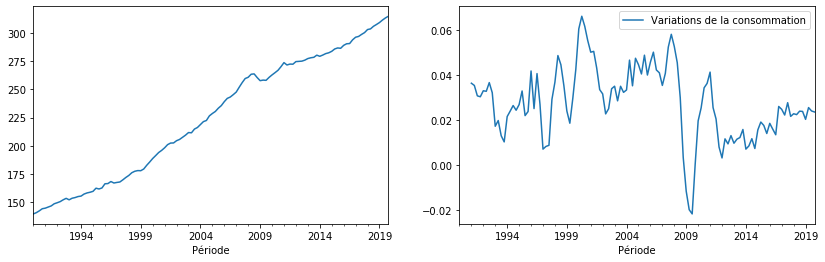

In [101]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4))
conso['TOTAL '].plot(ax=ax1,label='Dépenses de consommationd des ménages')
yty_var.plot(ax=ax2,label='Variations de la consommation')
plt.legend()
plt.show()

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

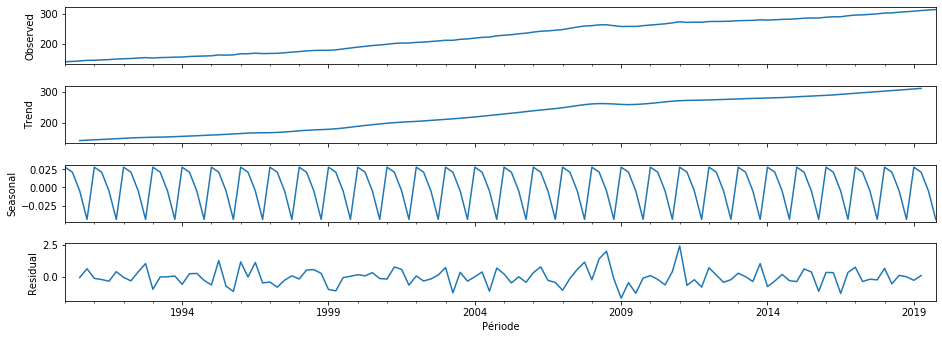

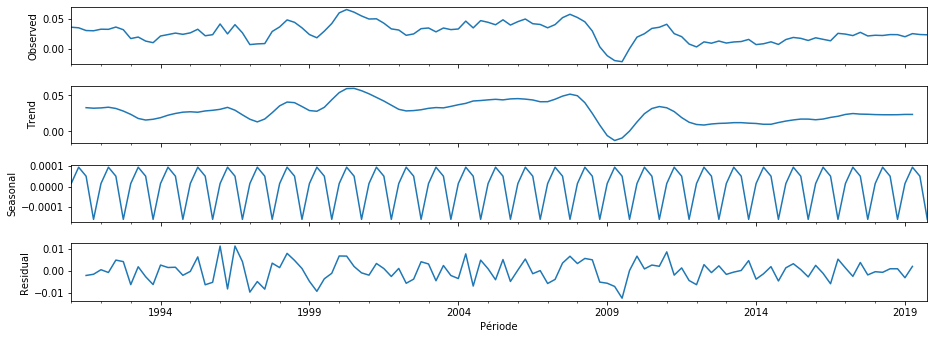

In [55]:
fig = seasonal_decompose(conso['TOTAL ']).plot()

fig.set_size_inches(15,5)

fig2 = seasonal_decompose(yty_var).plot()
fig2.set_size_inches(15,5)

plt.show()

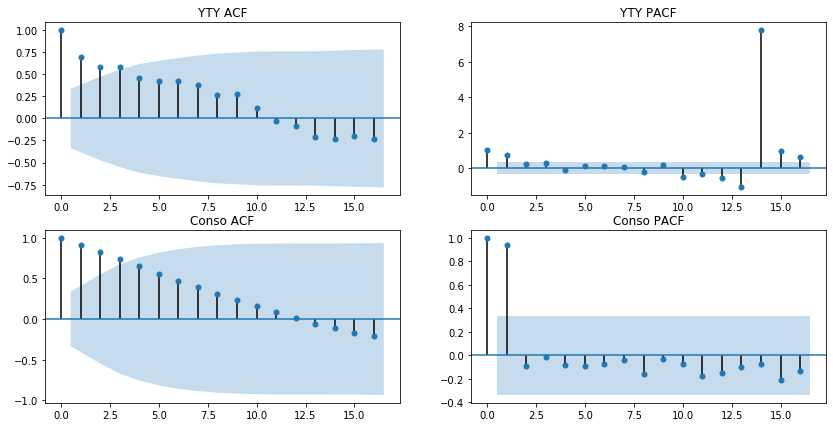

In [86]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig2, axes2 = plt.subplots(2,2, figsize=(14,7))
plot_acf(yty_var.loc['2011-09-30':], ax=axes2[0][0], title="YTY ACF")
plot_pacf(yty_var.loc['2011-09-30':], ax=axes2[0][1], title="YTY PACF")
plot_acf(conso['TOTAL '].loc['2011-09-30':],ax=axes2[1][0], title="Conso ACF")
plot_pacf(conso['TOTAL '].loc['2011-09-30':],ax=axes2[1][1], title="Conso PACF")
plt.show()

Nous pouvons donc d'abord envisager un ARMA(1,3)

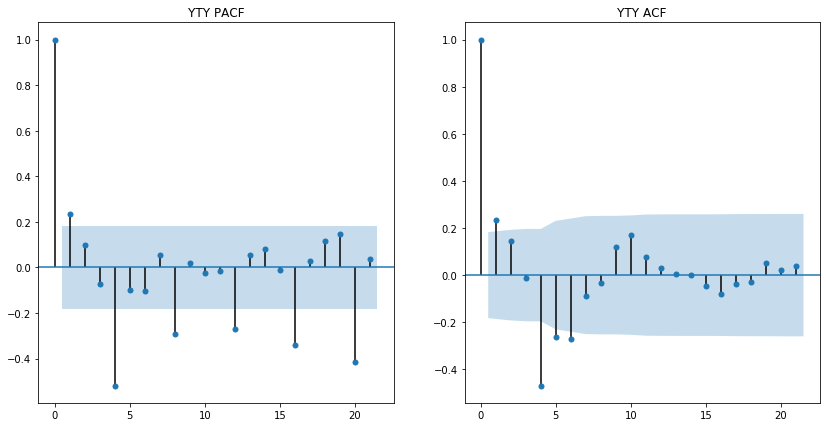

In [110]:
Y = conso['TOTAL '].diff(periods=4).diff(periods=1) # Modèle ARMA associé au SARIMA
fig2, axes2 = plt.subplots(1,2, figsize=(14,7))
plot_acf(Y.dropna(), ax=axes2[1], title="YTY ACF")
plot_pacf(Y.dropna(), ax=axes2[0], title="YTY PACF")
plt.show()

On peut tenter un SARIMA(1,1,1)(1,1,3)

In [112]:
import statsmodels.api as sm

In [118]:
SARIMA1 = sm.tsa.SARIMAX(conso['TOTAL '], order=(1,1,1), seasonal_order=(1,1,3,4)).fit()
print(SARIMA1.summary())

Statespace Model Results                                
Dep. Variable:                            TOTAL    No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 1, 3, 4)   Log Likelihood                -197.128
Date:                           Wed, 01 Apr 2020   AIC                            408.256
Time:                                   16:20:39   BIC                            427.470
Sample:                               03-31-1990   HQIC                           416.055
                                    - 12-31-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7638      0.204      3.741      0.000       0.364       1.164
ma.L1         -0.5103      0.215     -2.372      0.018      -0.932      -0.0

In [132]:
predict = SARIMA1.get_prediction()
predict_ci = predict.conf_int()

predict_dy = SARIMA1.get_prediction(dynamic='2011-03-31')
predict_dy_ci = predict_dy.conf_int()

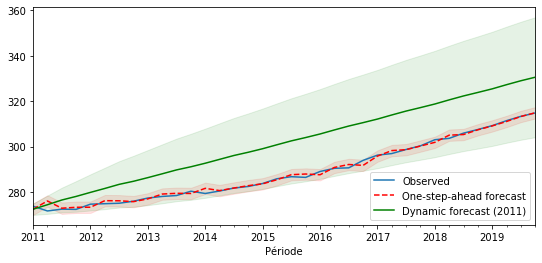

In [138]:
fig, ax = plt.subplots(figsize=(9,4))

conso['TOTAL '].loc['2011-03-31':].plot(ax=ax, label='Observed')

predict.predicted_mean.loc['2011-03-31':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc['2011-03-31':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

predict_dy.predicted_mean.loc['2011-03-31':].plot(ax=ax, style='g', label='Dynamic forecast (2011)')
ci = predict_dy_ci.loc['2011-03-31':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

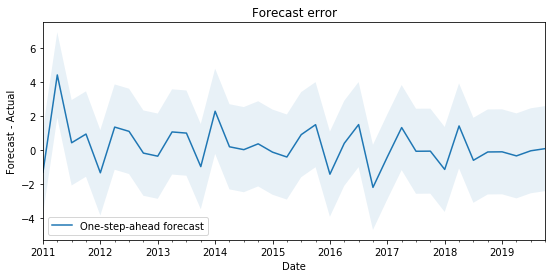

In [143]:
# Graph
fig, ax = plt.subplots(figsize=(9,4))

ax.set(title='Forecast error', xlabel='Date', ylabel='Forecast - Actual')

predict_error = predict.predicted_mean - conso['TOTAL ']
predict_error.loc['2011-03-31':].plot(ax=ax, label='One-step-ahead forecast')
ci = predict_ci.loc['2011-03-31':].copy()
ci.iloc[:,0] -= conso['TOTAL '].loc['2011-03-31':]
ci.iloc[:,1] -= conso['TOTAL '].loc['1977-03-31':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.1)

predict_dy_error = predict_dy.predicted_mean - conso['TOTAL ']
predict_dy_error.loc['2011-03-31':].plot(ax=ax, style='r', label='Dynamic forecast (1978)')
ci = predict_dy_ci.loc['2011-03-31':].copy()
ci.iloc[:,0] -= conso['TOTAL '].loc['2011-03-31':]
ci.iloc[:,1] -= conso['TOTAL '].loc['2011-03-31':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

legend = ax.legend(loc='lower left');
legend.get_frame().set_facecolor('w')

## Prédiction naïve (modèles AR)

On peut ainsi envisager pour yty_var un ARMA(3,1).

In [141]:
from statsmodels.tsa.arima_model import ARMA

arma = ARMA()

In [113]:
pd.DataFrame(conso.iloc[:len(conso)-1,:]['TOTAL ']).merge(conso.iloc[:len(conso)-1-1,:]['TOTAL '],on='Période')

,TOTAL _x,TOTAL _y
Période,,
1990T1,139.6,139.6
1990T2,140.7,140.7
1990T3,142.3,142.3
1990T4,144.2,144.2
1991T1,144.7,144.7
...,...,...
2018T2,303.6,303.6
2018T3,305.9,305.9
2018T4,307.5,307.5


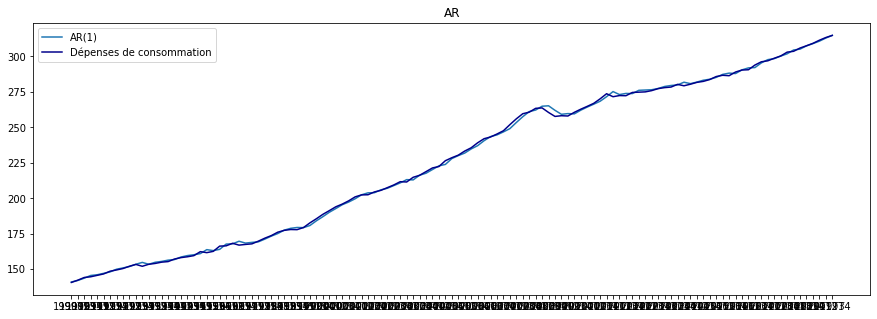

In [127]:
from sklearn.linear_model import LinearRegression
import numpy as np

figure, axes = plt.subplots(figsize=(15,5))


for i in range(1):
    reg = LinearRegression()
    Y = conso.iloc[1+i:,:]['TOTAL ']
    X = conso.iloc[:len(conso)-1-i,:]['TOTAL '][:,np.newaxis]
    reg.fit(X,Y)

    axes.plot(reg.predict(X),label='AR('+str(i+1)+')')
    axes.set_title('AR')

axes.plot(Y,color='darkblue',label='Dépenses de consommation')
plt.legend()
plt.show()

### En yty-var

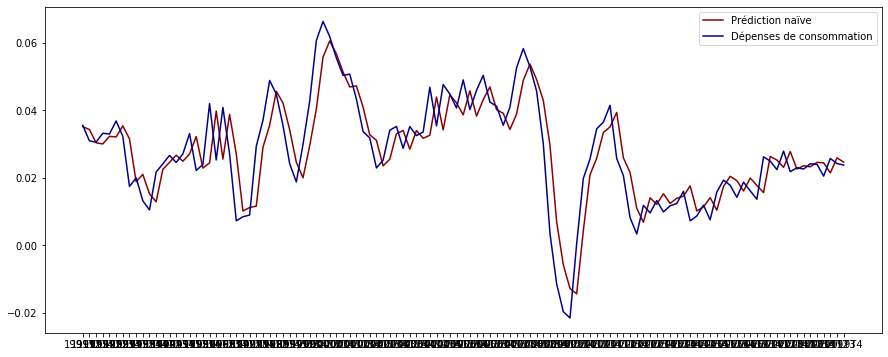

In [126]:
reg = LinearRegression()
Y = yty_var.iloc[1:,:]
X = yty_var.iloc[:len(yty_var)-1,:]['Variations de la consommation'][:,np.newaxis]

reg.fit(X,Y)

figure, axes = plt.subplots(figsize=(15,6))
axes.plot(reg.predict(X),color='darkred',label='Prédiction naïve')
axes.plot(Y,color='darkblue',label='Dépenses de consommation')

plt.legend()
plt.show()

In [16]:
from statsmodels.tsa.stattools import adfuller # Pour vérifier la trend-stationnarité de la série

In [27]:
result = adfuller(conso['TOTAL '],regression='ct')

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.884954
p-value: 0.662429


Ce n'est absolument pas stationnaire.

In [23]:
result = adfuller(yty_var['Variations de la consommation'],regression='c')

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.568250
p-value: 0.099738


La série dans son ensemble n'est pas vraiment trend-stationnaire...

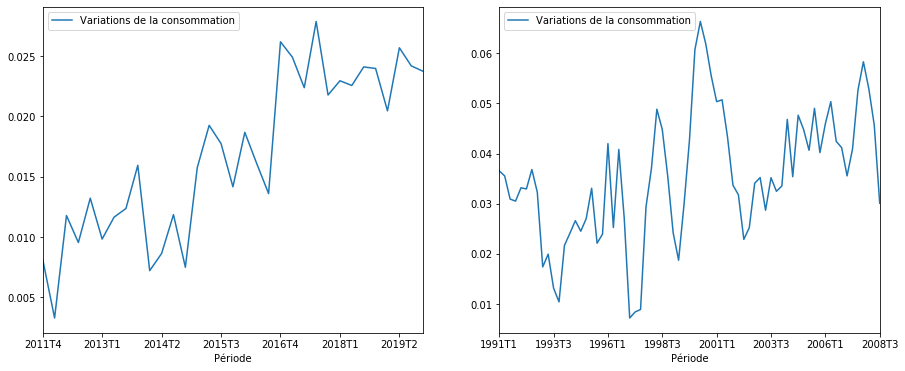

In [39]:
fig2, (ax3,ax4) = plt.subplots(1,2,figsize=(15,6))
yty_var.loc['2011T4':,:].plot(ax=ax3)
yty_var.loc[:'2008T3',:].plot(ax=ax4)
plt.show()

In [42]:
result = adfuller(yty_var.loc['2011T4':,:]['Variations de la consommation'],regression='ct')

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.615165
p-value: 0.028588


A partir de du 3e trimestre de 2011, on retrouve une certaine trend-stationnarité.